In [ ]:
import pickle
import numpy as np
import ase.io
from ase.io import extxyz
from ase.build import fcc100, add_adsorbate, molecule
from ase import Atoms
from ase.calculators.emt import EMT
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import os

import ase.io
from ase.build import bulk
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.calculators.emt import EMT
from ase.optimize import BFGS
import matplotlib.pyplot as plt
import lmdb
import pickle
from tqdm import tqdm
import torch
import os
from pymatgen.core.composition import Composition
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.datasets import SinglePointLmdbDataset, TrajectoryLmdbDataset
dic_ads = pickle.load(open('/Users/rimassouel/Documents/ocp/explo/mapping_adslab_slab.pkl','rb'))
dic_data = pickle.load(open('/Users/rimassouel/Documents/ocp/explo/oc20_data_mapping.pkl','rb'))



In [18]:
ALL_LIST = []
with open('to_extract.txt', 'r') as f : 
    lines = f.readlines()
    for line in lines : 
        a = line.split('/')[-1].split('.')[0]
        ALL_LIST.append(a)
        

In [19]:
OH_list = []
C1_list = []

OH_ad = []
C1_ad = []
for id in ALL_LIST :
    ads = dic_data[id]['ads_symbols']
    ads = ads.replace('*', '')
    comp = Composition(ads)
    formula = (comp.formula).split(' ')
    formula_no_digit = formula.copy()
    for j in range(len(formula)):
        formula_no_digit[j] = ''.join([i for i in formula[j] if not i.isdigit()])



    if 'N' not in formula_no_digit :
        if 'C' not in formula_no_digit :
            OH_list.append(id)
            OH_ad.append(ads)
        elif 'C2' not in formula :
            and formula != 'CH2OH'
            C1_list.append(id)
            C1_ad.append(ads)


## Adsobates splits

In [20]:
uniques_oh, count_oh = np.unique(OH_ad, return_counts=True)
uniques_c1, count_c1 = np.unique(C1_ad, return_counts=True)

print(uniques_oh)
print(uniques_c1)

['H' 'O' 'OH' 'OH2']
['C' 'CH2' 'CH2O' 'CH2OH' 'CH3' 'CH4' 'CHOH' 'OCH3' 'OHCH3']


Text(0.5, 1.0, 'distribution of O/H -based adsorbates')

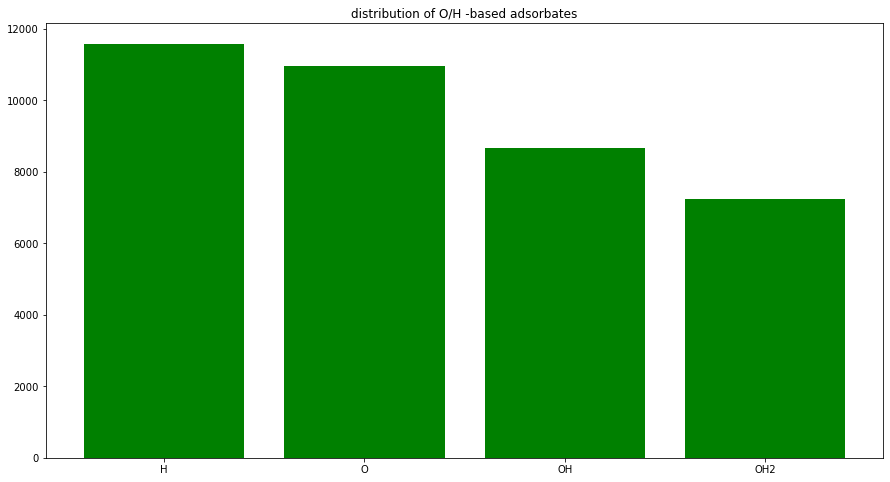

In [21]:
plt.figure(figsize=(15,8))
plt.bar([ ad for ad in uniques_oh], count_oh, color='g')
plt.title('distribution of O/H -based adsorbates')

Text(0.5, 1.0, 'distribution of C1 -based adsorbates')

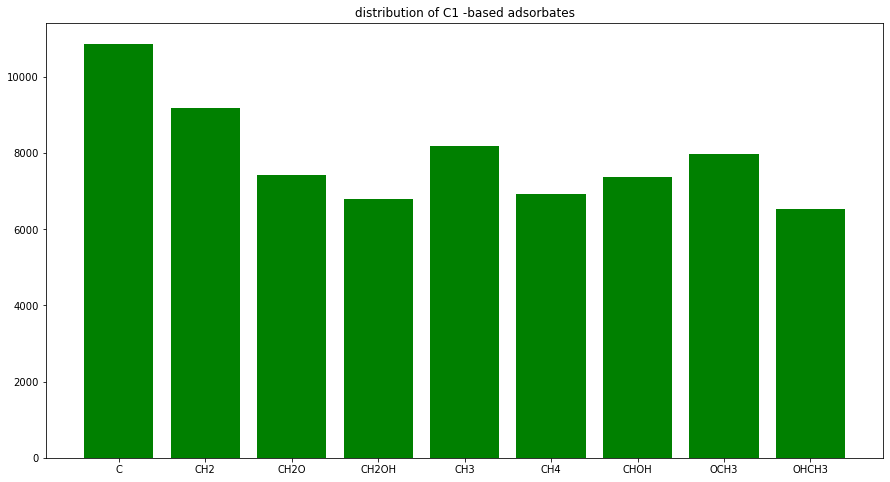

In [22]:
plt.figure(figsize=(15,8))
plt.bar([ ad for ad in uniques_c1], count_c1, color='g')
plt.title('distribution of C1 -based adsorbates')

In [23]:
AD_TRAIN = ['H' ,'O' ,'OH','C' ,'CH2', 'CH2O', 'CHOH']
AD_VAL = ['CH3' ,'OCH3' ]
AD_TEST = ['OHCH3','OH2','CH4' ]

## Ads dics

In [24]:
dic_train = {}
dic_val = {}
dic_test = {}

for file, ad in zip(OH_list, OH_ad) :
    if ad in AD_TRAIN : 
        if ad in dic_train :
            dic_train[ad].append(file)
        else : 
            dic_train[ad] = [file]
    elif ad in AD_VAL : 
        if ad in dic_val :
            dic_val[ad].append(file)
        else : 
            dic_val[ad] = [file]
    else : 
        if ad in dic_test :
            dic_test[ad].append(file)
        else :
            dic_test[ad] = [file]
for file, ad in zip(C1_list, C1_ad) :
    if ad in AD_TRAIN : 
        if ad in dic_train :
            dic_train[ad].append(file)
        else : 
            dic_train[ad] = [file]
    elif ad in AD_VAL : 
        if ad in dic_val :
            dic_val[ad].append(file)
        else : 
            dic_val[ad] = [file]
    else : 
        if ad in dic_test :
            dic_test[ad].append(file)
        else : 
            dic_test[ad] = [file]

## Adsorbates 

In [30]:
with open('train_files_ads.txt', 'w') as f:
    for ad in dic_train : 
        for item in dic_train[ad]:
            item = item+'.traj'
            f.write("%s\n" % item)
    f.close()
    
with open('val_files_ads.txt', 'w') as f:
    for ad in dic_val : 
        for item in dic_val[ad]:
            item = item+'.traj'
            f.write("%s\n" % item)
    f.close()
with open('test_files_ads.txt', 'w') as f:
    for ad in dic_test : 
        for item in dic_test[ad]:
            item = item+'.traj'
            f.write("%s\n" % item)
    f.close()

## Catalysts splits

In [17]:
def get_catalysts(ads_list) :
    UNARY = []
    UNARY_file = []
    BINARY = []
    BINARY_file = []
    BINARY_COMP = []
    TERNARY = []
    TERNARY_COMP = []
    TERNARY_file = []

    for system in ads_list:
         # Extract Data object

        id = system
        ads = dic_data[id]['ads_symbols']
        cata_raw = dic_data[id]['bulk_symbols']

        comp = Composition(cata_raw)
        formula = (comp.formula).split(' ')
        for j in range(len(formula)) :
             formula[j] = ''.join([i for i in formula[j] if not i.isdigit()])


        reduced = result = ''.join([i for i in comp.reduced_formula if not i.isdigit()])

        if len(formula) ==1 :
            UNARY.append(reduced)
            UNARY_file.append(system)
        elif len(formula) == 2 :
            BINARY.append(reduced)
            BINARY_COMP.append(formula)
            BINARY_file.append(system)
        elif len(formula) == 3 :
            TERNARY.append(reduced)
            TERNARY_COMP.append(formula)  
            TERNARY_file.append(system)
    return (UNARY, UNARY_file), (BINARY, BINARY_file, BINARY_COMP), (TERNARY, TERNARY_file, TERNARY_COMP)

Text(0.5, 1.0, 'distribution of H unary catalysts')

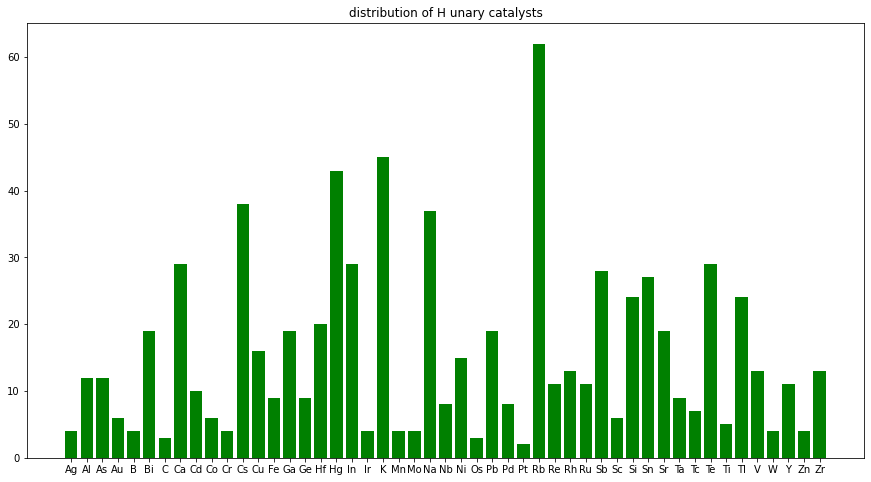

In [19]:
(UNARY, UNARY_file), (BINARY, BINARY_file, BINARY_COMP), (TERNARY, TERNARY_file, TERNARY_COMP) = get_catalysts(dic_train['H'])
uniques_h, count_h = np.unique(UNARY, return_counts=True)
plt.figure(figsize=(15,8))
plt.bar([ cat for cat in uniques_h], count_h, color='g')
plt.title('distribution of H unary catalysts')

Text(0.5, 1.0, 'distribution of O unary catalysts')

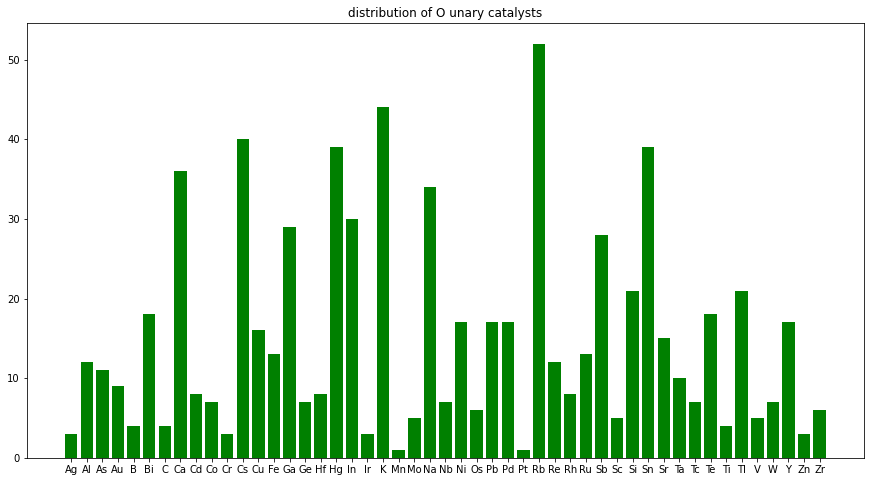

In [20]:
(UNARY, UNARY_file), (BINARY, BINARY_file, BINARY_COMP), (TERNARY, TERNARY_file, TERNARY_COMP) = get_catalysts(dic_train['O'])
uniques_o, count_o = np.unique(UNARY, return_counts=True)
plt.figure(figsize=(15,8))
plt.bar([ cat for cat in uniques_o], count_o, color='g')
plt.title('distribution of O unary catalysts')

Text(0.5, 1.0, 'distribution of C unary catalysts')

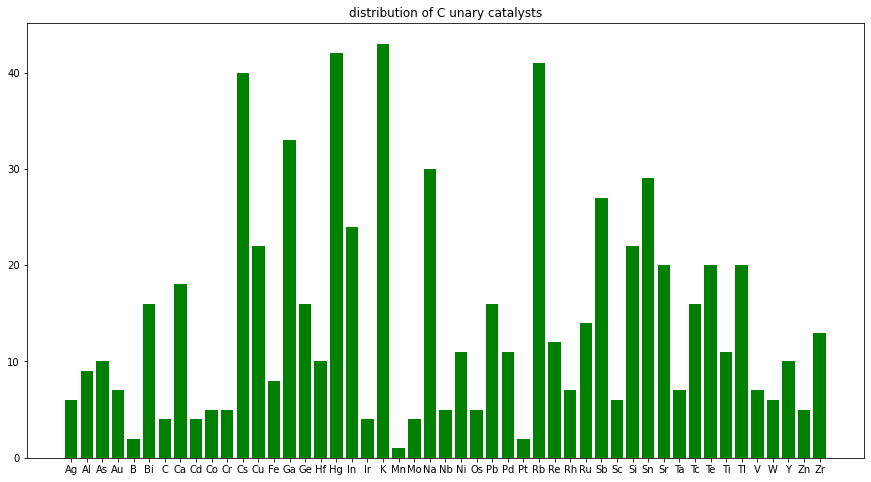

In [21]:
(UNARY, UNARY_file), (BINARY, BINARY_file, BINARY_COMP), (TERNARY, TERNARY_file, TERNARY_COMP) = get_catalysts(dic_train['C'])
uniques_c, count_c = np.unique(UNARY, return_counts=True)
plt.figure(figsize=(15,8))
plt.bar([ cat for cat in uniques_c], count_c, color='g')
plt.title('distribution of C unary catalysts')


## OOD Catalysts adsorbates  splits 


### Get val/test/train catalysts for H20 split

In [1]:
train_file = '/Users/rimassouel/Documents/ocp/explo/h20/train_files.txt'
val_file = '/Users/rimassouel/Documents/ocp/explo/h20/val_files.txt'
test_file = '/Users/rimassouel/Documents/ocp/explo/h20/test_files.txt'

In [12]:
def get_uniques_catalyst(file) :
    
    CATA = []
    with open(file, 'r') as f :
        lines = f.readlines()
        
        for l in lines : 
            id = l.replace('.traj\n','')
            cata_raw = dic_data[id]['bulk_symbols']
            CATA.append(cata_raw)
    return np.unique(CATA, return_counts = True)
            
           
           

In [16]:
train_catalysts, train_counts = get_uniques_catalyst(train_file)
val_catalysts, val_counts = get_uniques_catalyst(val_file)
test_catalysts, test_counts = get_uniques_catalyst(test_file)

In [25]:
def filter_dic(dic, catalysts):
    new_dic = {}
    
    for key in dic :
        new_dic[key] = []
        for traj in dic[key] :
            cata_raw = dic_data[traj]['bulk_symbols']
            if cata_raw in catalysts : 
                new_dic[key].append(traj)
    return new_dic 
            

In [29]:
dic_train_both = filter_dic(dic_train, train_catalysts)
dic_val_both = filter_dic(dic_val, val_catalysts)
dic_test_both = filter_dic(dic_test, test_catalysts)

## DIC all ood catalysts

In [30]:
dic_all = {}
for file , ad in zip(OH_list, OH_ad) :

    if ad in dic_all : 
        dic_all[ad].append(file)
    else : dic_all[ad] = [file]
for file , ad in zip(C1_list, C1_ad) :

    if ad in dic_all : 
        dic_all[ad].append(file)
    else : dic_all[ad] = [file]
   

In [31]:
dic_train_cat = filter_dic(dic_all, train_catalysts)
dic_val_cat = filter_dic(dic_all, val_catalysts)
dic_test_cat = filter_dic(dic_all, test_catalysts)

#### Distributions in OOD catalysts splits

In [33]:
print('distribution in ood catalysts TRAIN')
for key in dic_train_cat : 
    print(key, len(dic_train_cat[key]))

distribution in ood catalysts TRAIN
H 4903
OH 3689
OH2 4173
O 4686
CH2 3892
OCH3 3337
C 4675
CH4 2970
CHOH 3179
OHCH3 2721
CH3 3436
CH2O 3277
CH2OH 2849


In [34]:
print('distribution in ood catalysts VAL')
for key in dic_val_cat : 
    print(key, len(dic_val_cat[key]))

distribution in ood catalysts VAL
H 1051
OH 826
OH2 1054
O 1080
CH2 837
OCH3 739
C 1055
CH4 663
CHOH 682
OHCH3 637
CH3 778
CH2O 753
CH2OH 715


In [35]:
print('distribution in ood catalysts TEST')
for key in dic_test_cat : 
    print(key, len(dic_test_cat[key]))

distribution in ood catalysts TEST
H 2134
OH 1733
OH2 2273
O 2076
CH2 1744
OCH3 1471
C 2056
CH4 1371
CHOH 1422
OHCH3 1271
CH3 1536
CH2O 1500
CH2OH 1365


#### Distribution in OOD both splits

In [36]:
print('distribution in ood both TRAIN')
for key in dic_train_both : 
    print(key, len(dic_train_both[key]))

distribution in ood both TRAIN
H 4903
OH 3689
O 4686
CH2 3892
C 4675
CHOH 3179
CH2O 3277


In [37]:
print('distribution in ood both VAL')
for key in dic_val_both : 
    print(key, len(dic_val_both[key]))

distribution in ood both VAL
OCH3 739
CH3 778


In [38]:
print('distribution in ood both TEST')
for key in dic_test_both : 
    print(key, len(dic_test_both[key]))

distribution in ood both TEST
OH2 2273
CH4 1371
OHCH3 1271
CH2OH 1365


In [42]:
with open('train_files_both.txt', 'w') as f:
    for ad in dic_train_both : 
        for item in dic_train_both[ad]:
            item = item+'.traj'
            f.write("%s\n" % item)
    f.close()
    
with open('val_files_both.txt', 'w') as f:
    for ad in dic_val_both : 
        for item in dic_val_both[ad]:
            item = item+'.traj'
            f.write("%s\n" % item)
    f.close()
with open('test_files_both.txt', 'w') as f:
    for ad in dic_test_both : 
        for item in dic_test_both[ad]:
            item = item+'.traj'
            f.write("%s\n" % item)
    f.close()

In [43]:
with open('train_files_cat.txt', 'w') as f:
    for ad in dic_train_cat : 
        for item in dic_train_cat[ad]:
            item = item+'.traj'
            f.write("%s\n" % item)
    f.close()
    
with open('val_files_cat.txt', 'w') as f:
    for ad in dic_val_cat : 
        for item in dic_val_cat[ad]:
            item = item+'.traj'
            f.write("%s\n" % item)
    f.close()
with open('test_files_cat.txt', 'w') as f:
    for ad in dic_test_cat : 
        for item in dic_test_cat[ad]:
            item = item+'.traj'
            f.write("%s\n" % item)
    f.close()